In [1]:
import json
import numpy as np
import csv

issues = []

with open("data/leo/issues.tsv", 'r', encoding="utf-8") as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    
    for row in tsvin:
        columns = []
        columns.append(row[1])
        columns.append(row[2])
        columns.append(row[3])
        
        issues.append(columns)

9117

In [2]:
# Create texts
import re

sub_texts = []    
    
# Filter
for t in issues:
    a = ''
    a = re.compile('[0-9]+').sub('0', a)
    a = re.compile('[a-z0-9_+-.]+@[a-z0-9_+-.]+').sub('', a)

    columns = []
    columns.append(a)
    columns.append(t[1])
    columns.append(t[2])

    if len(a) > 0:
        sub_texts.append(columns)
    
sub_texts.pop(0)

['question', 'answer', 'category']

In [3]:
# Create labels
labels = []
texts = []
threashold = 700
cnt1 = 0
cnt2 = 0
cnt3 = 0

for i, row in enumerate(sub_texts):
    if 'アカウント' in row[2]:
        if cnt2 < threashold:
            cnt2 += 1
            labels.append(2)
            texts.append(row[0])
    elif '課金' in row[2]:
        if cnt3 < threashold:
            cnt3 += 1
            labels.append(3)
            texts.append(row[0])
    else:
        if cnt1 < threashold:
            cnt1 += 1
            texts.append(row[0])
            labels.append(1)

In [4]:
import MeCab
import re

def tokenize(text):
    wakati = MeCab.Tagger("-O wakati")
    wakati.parse("")
    words = wakati.parse(text)
    
    if words[-1] == u"\n":
        words = words[:-1]
        
    return words

texts = [tokenize(a) for a in texts]

In [5]:
from keras.utils.np_utils import to_categorical

categorical_labels = to_categorical(labels)

/home/jupyter/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 1000
training_samples = 1600
validation_samples = len(texts) - training_samples
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
print(len(labels))
print(len(indices))
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 6831 unique tokens.
Shape of data tensor:(2088, 1000)
Shape of label tensor:(2088, 4)
2088
2088


In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM, Bidirectional
import tensorflow as tf

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Embedding(15000, 100, input_length=maxlen))
    model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(32))
    model.add(Dense(4, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

history = model.fit(x_train, y_train, epochs=25, batch_size=100, validation_split=0.2, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         1500000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 1000, 32)          17024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 1,525,476
Trainable params: 1,525,476
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 488 samples
Epoch 1/25
1600/1600 [==============================] - 15s 9ms/step - loss: 1.3608 - acc: 0.3169 - val_loss: 1.2998 - val_acc: 0.3504
Epoch 2/25
1600/1600 [==============================] - 14s 9ms/step - loss: 1.182

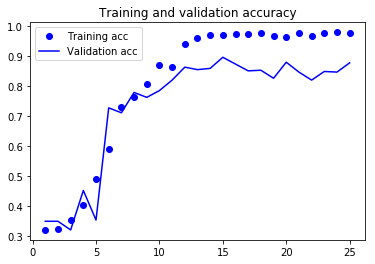

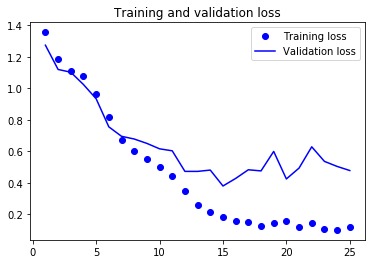

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()